# Introduction to Dandiset 001341: Barrel Cortex Navigation Study

⚠️ **IMPORTANT**: This notebook was AI-generated and has not been fully verified by humans. Please be cautious when interpreting the code or results. Always validate the outputs and analyses.

This notebook explores data from [DANDI:001341](https://neurosift.app/dandiset/001341), which contains electrophysiological recordings from the C2 barrel column of the whisker somatosensory cortex (wS1) in mice during tactile virtual reality (VR) navigation.

## Experiment Overview
* Mice are head-fixed on a suspended ball with two walls placed on either side
* The walls' lateral movement is coupled to the mouse's trajectory in real-time
* When the mouse moves left, the walls move in from the left, encouraging centering behavior
* The task presents alternating left (contralateral) and right (ipsilateral) turns
* Each trial has:
  - 100cm closed-loop baseline straight running
  - 2-second open-loop turn (left or right)
* Recording location: C2 barrel column
* Note: This is an unrewarded version of a two-alternative forced choice (2AFC) task

Data was collected by Alex Armstrong and Yurii Vlasov at the University of Illinois.

## Setup
First, let's import the required libraries and load the data. We'll use the lindi library which enables efficient streaming access to the remote NWB files.

In [1]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to load NWB file
def load_nwb(asset_id):
    url = f"https://api.dandiarchive.org/api/assets/{asset_id}/download/"
    print(f"Loading NWB file from {url}")
    f = lindi.LindiH5pyFile.from_lindi_file(f"https://lindi.neurosift.org/dandi/dandisets/001341/assets/{asset_id}/nwb.lindi.json")
    return pynwb.NWBHDF5IO(file=f, mode='r').read()

# Let's use the first subject's data
nwb = load_nwb("e3d421c3-13bf-4b2e-b0f9-b6357a885de9")

Loading NWB file from https://api.dandiarchive.org/api/assets/e3d421c3-13bf-4b2e-b0f9-b6357a885de9/download/


## Exploring Trial Structure

First, let's examine the trials data. Note: As mentioned in the documentation, we should use 'file_start_time' and 'file_stop_time' instead of 'start_time' and 'stop_time'.

Total number of trials: 1611

Trial duration statistics (seconds):
count    1611.000000
mean        3.863953
std         2.474222
min        -3.410000
25%         2.000000
50%         3.355000
75%         5.008000
max        18.416000
Name: duration, dtype: float64


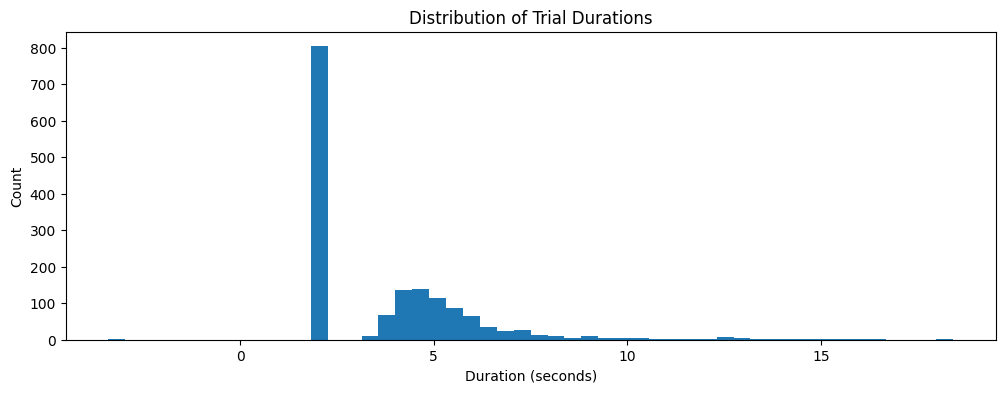

In [2]:
# Load trials data into a pandas DataFrame for easier analysis
trials = nwb.intervals['trials']
trial_df = pd.DataFrame({
    'start': trials['file_start_time'][:],
    'stop': trials['file_stop_time'][:],
    'duration': trials['file_stop_time'][:] - trials['file_start_time'][:]
})

print(f"Total number of trials: {len(trial_df)}")
print("\nTrial duration statistics (seconds):")
print(trial_df['duration'].describe())

# Plot trial durations
plt.figure(figsize=(12, 4))
plt.hist(trial_df['duration'], bins=50)
plt.title('Distribution of Trial Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

## Behavioral Data

Let's look at some behavioral metrics during navigation. We'll examine the first 1000 timepoints of forward and lateral movements.
Note: We're only loading a small subset of the data as the full dataset is large and hosted remotely.

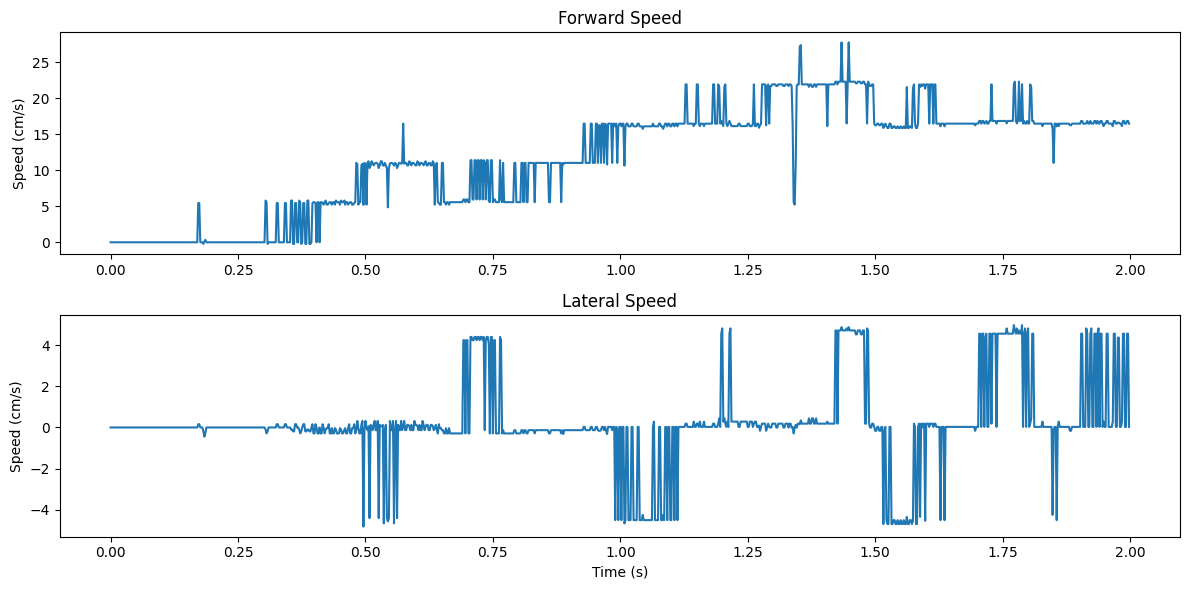

In [3]:
# Load the first 1000 timepoints of speed and position data
n_points = 1000

# Forward and lateral speeds
speed_for = nwb.acquisition['speed_for']
speed_lat = nwb.acquisition['speed_lat']

times = speed_for.timestamps[0:n_points]
forward_speed = speed_for.data[0:n_points]
lateral_speed = speed_lat.data[0:n_points]

# Plot speeds
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(times, forward_speed)
plt.title('Forward Speed')
plt.ylabel('Speed (cm/s)')

plt.subplot(2, 1, 2)
plt.plot(times, lateral_speed)
plt.title('Lateral Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.tight_layout()
plt.show()

## Neural Data: Units Analysis

Let's explore the recorded units and their quality metrics. The dataset includes various quality metrics that can help us assess the reliability of each unit.

Available quality metrics: ('peak_channel', 'depth', 'layer', 'unit_type', 'snr', 'duration', 'PT_ratio', 'repolarization_slope', 'recovery_slope', 'amplitude_waveform', 'spread', 'velocity_above', 'velocity_below', 'epoch_name_waveform_metrics', 'firing_rate', 'presence_ratio', 'isi_viol', 'amplitude_cutoff', 'isolation_distance', 'l_ratio', 'd_prime', 'nn_hit_rate', 'nn_miss_rate', 'max_drift', 'cumulative_drift', 'epoch_name_quality_metrics', 'spike_times')

Number of units: 65

Quality metrics summary:
             snr  isolation_distance       l_ratio   isi_viol  firing_rate
count  65.000000           62.000000  6.200000e+01  65.000000    65.000000
mean    0.050499           41.139690  1.290768e+00   0.131216     6.031560
std     0.010999           29.694229  3.313313e+00   0.144066     7.321861
min     0.026794            7.665655  1.012833e-12   0.000000     0.102180
25%     0.043024           24.279437  4.462201e-02   0.013214     1.845235
50%     0.049348           34.404850  

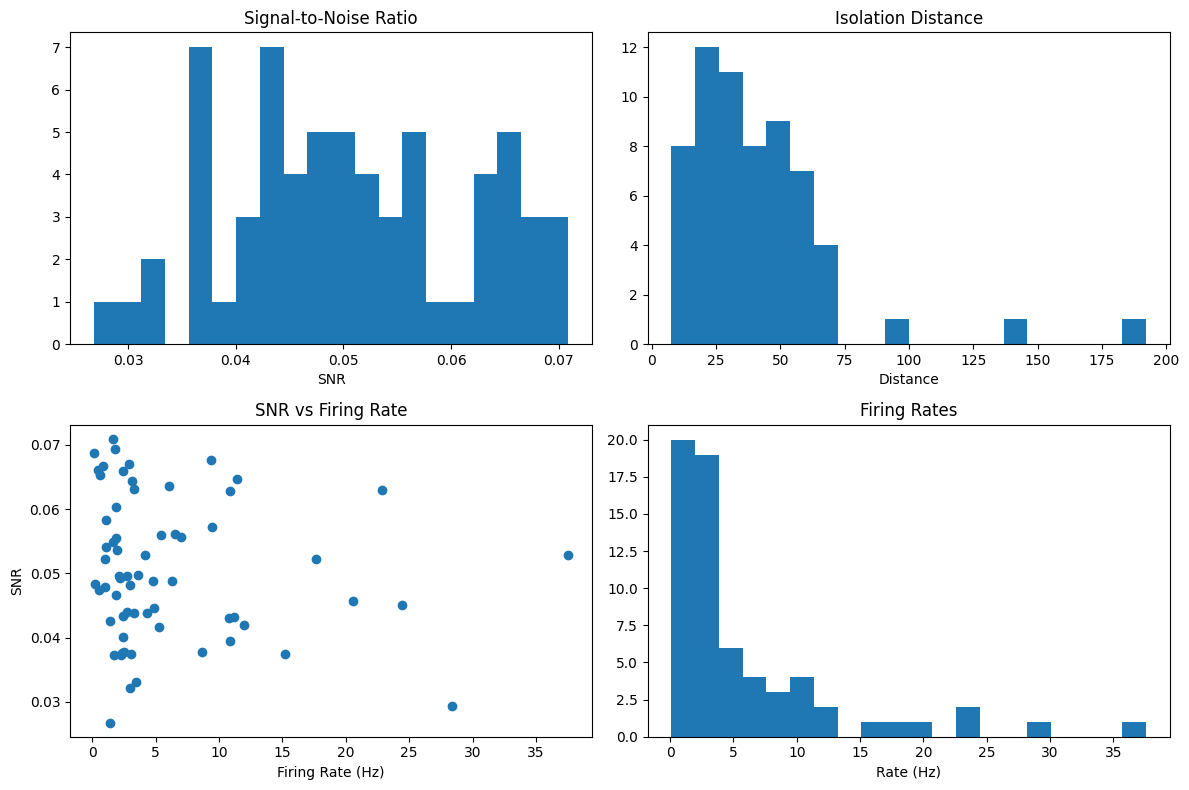

In [4]:
# Get units data
units = nwb.units
unit_ids = units['id'][:]

# Create a DataFrame with quality metrics
quality_metrics = ['snr', 'isolation_distance', 'l_ratio', 'isi_viol', 'firing_rate']
unit_df = pd.DataFrame()

for metric in quality_metrics:
    unit_df[metric] = units[metric][:]

# Add unit type and depth information
unit_df['unit_type'] = units['unit_type'][:]
unit_df['depth'] = units['depth'][:]

print("Available quality metrics:", units.colnames)
print(f"\nNumber of units: {len(unit_ids)}")
print("\nQuality metrics summary:")
print(unit_df[quality_metrics].describe())

# Plot some key quality metrics
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(unit_df['snr'], bins=20)
plt.title('Signal-to-Noise Ratio')
plt.xlabel('SNR')

plt.subplot(2, 2, 2)
plt.hist(unit_df['isolation_distance'], bins=20)
plt.title('Isolation Distance')
plt.xlabel('Distance')

plt.subplot(2, 2, 3)
plt.scatter(unit_df['firing_rate'], unit_df['snr'])
plt.title('SNR vs Firing Rate')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('SNR')

plt.subplot(2, 2, 4)
plt.hist(unit_df['firing_rate'], bins=20)
plt.title('Firing Rates')
plt.xlabel('Rate (Hz)')

plt.tight_layout()
plt.show()

## Creating a PSTH (Peri-Stimulus Time Histogram)

Let's create a PSTH for one of the units around trial starts. We'll:
1. Select a unit with good quality metrics
2. Get its spike times
3. Align these to trial starts
4. Create the PSTH

Selected unit 12 for PSTH:
SNR: 0.05
Firing rate: 17.67 Hz


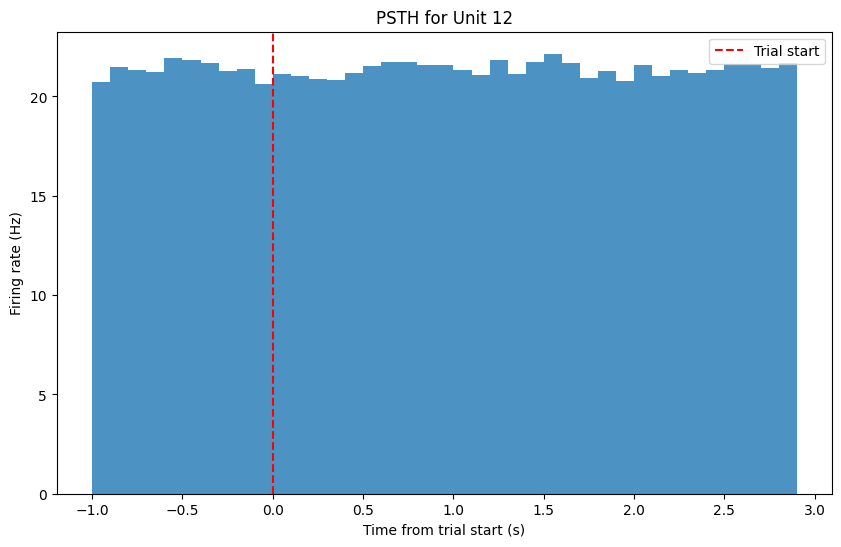

In [5]:
# Find a unit with good SNR and firing rate
good_units = unit_df[
    (unit_df['snr'] > unit_df['snr'].median()) & 
    (unit_df['firing_rate'] > unit_df['firing_rate'].median())
].index

# Select the first good unit
unit_idx = good_units[0]
unit_id = unit_ids[unit_idx]
selected_unit_spikes = units['spike_times'][unit_idx]

print(f"Selected unit {unit_id} for PSTH:")
print(f"SNR: {unit_df['snr'][unit_idx]:.2f}")
print(f"Firing rate: {unit_df['firing_rate'][unit_idx]:.2f} Hz")

# Parameters for PSTH
window = (-1, 3)  # 1 second before to 3 seconds after trial start
bin_size = 0.1  # 100ms bins

# Create PSTH
bins = np.arange(window[0], window[1], bin_size)
psth = np.zeros(len(bins)-1)
trial_starts = trial_df['start'].values

# Compute PSTH
for start_time in trial_starts:
    # Find spikes within window of this trial start
    relative_times = selected_unit_spikes - start_time
    mask = (relative_times >= window[0]) & (relative_times < window[1])
    trial_spikes = relative_times[mask]
    
    # Add to histogram
    hist, _ = np.histogram(trial_spikes, bins=bins)
    psth += hist

# Convert to firing rate
psth = psth / (len(trial_starts) * bin_size)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1] + bin_size/2, psth, width=bin_size, alpha=0.8)
plt.axvline(0, color='r', linestyle='--', label='Trial start')
plt.xlabel('Time from trial start (s)')
plt.ylabel('Firing rate (Hz)')
plt.title(f'PSTH for Unit {unit_id}')
plt.legend()
plt.show()

## Summary

This notebook demonstrated how to:
1. Load and explore trial structure data
2. Visualize behavioral metrics (speeds)
3. Examine unit quality metrics
4. Create a PSTH aligned to trial starts

Keep in mind:
- We only loaded small subsets of the time series data
- The full dataset contains multiple subjects and sessions
- Various quality metrics are available for unit selection
- The trial structure includes both straight running and turning periods

For further exploration, you might:
- Compare neural responses between left and right turns
- Analyze speed profiles during different trial phases
- Examine relationships between unit depths and response properties
- Create more sophisticated analyses of neural activity patterns